In [261]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from IPython import display
display.set_matplotlib_formats("svg")



In [262]:
df1 = pd.read_csv("train.csv")
df2 = pd.read_csv("test.csv")

In [263]:
df1.drop(['Name','Ticket','Cabin','Embarked'],axis=1,inplace=True)
df2.drop(['Name','Ticket','Cabin','Embarked'],axis=1,inplace=True)

In [264]:
lst1 = [0 if gen=="male" else 1 for gen in df1['Sex']]
lst2 = [0 if gen=="male" else 1 for gen in df2['Sex']]

df1['Sex'] = lst1
df2['Sex'] = lst2

In [265]:
lst = df1.columns.tolist()
lst = lst[:1]+lst[2:]+lst[1:2]
df1=df1[lst]
df1.head(10)

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Survived
0,1,3,0,22.0,1,0,7.2500,0
1,2,1,1,38.0,1,0,71.2833,1
2,3,3,1,26.0,0,0,7.9250,1
3,4,1,1,35.0,1,0,53.1000,1
4,5,3,0,35.0,0,0,8.0500,0
5,6,3,0,NaN,0,0,8.4583,0
6,7,1,0,54.0,0,0,51.8625,0
7,8,3,0,2.0,3,1,21.0750,0
8,9,3,1,27.0,0,2,11.1333,1
9,10,2,1,14.0,1,0,30.0708,1


In [266]:
m = df1['Age'].mean()
df1['Age'].fillna(value=m, inplace=True)
df1.head(10)

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Survived
0,1,3,0,22.000000,1,0,7.2500,0
1,2,1,1,38.000000,1,0,71.2833,1
2,3,3,1,26.000000,0,0,7.9250,1
3,4,1,1,35.000000,1,0,53.1000,1
4,5,3,0,35.000000,0,0,8.0500,0
5,6,3,0,29.699118,0,0,8.4583,0
6,7,1,0,54.000000,0,0,51.8625,0
7,8,3,0,2.000000,3,1,21.0750,0
8,9,3,1,27.000000,0,2,11.1333,1
9,10,2,1,14.000000,1,0,30.0708,1


In [267]:
X = torch.tensor(df1.drop("Survived", axis=1).values, dtype=torch.float)
y = torch.tensor(df1["Survived"].values, dtype=torch.float)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

torch.Size([712, 7]) torch.Size([712])
torch.Size([179, 7]) torch.Size([179])


In [268]:
train_data = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_data, shuffle=True, batch_size=12)

test_data = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_data, batch_size=len(test_data.tensors[0]))
len(test_data.tensors[0])

179

In [269]:
class Net(nn.Module):
    def __init__(self,inp,hidd1,hidd2,out):
        super().__init__()
        self.input = nn.Linear(in_features=inp, out_features=hidd1)
        self.hidden_1 = nn.Linear(in_features=hidd1, out_features=hidd2)
        self.output = nn.Linear(in_features=hidd2, out_features=out)
        
    def forward(self, x):
        x = F.relu(self.input(x))
        x = F.relu(self.hidden_1(x))
        x = self.output(x)
        return x
    
    
model = Net(7,20,25,2)
print(model)

Net(
  (input): Linear(in_features=7, out_features=20, bias=True)
  (hidden_1): Linear(in_features=20, out_features=25, bias=True)
  (output): Linear(in_features=25, out_features=2, bias=True)
)


In [270]:
num_epochs = 200
train_accuracies, test_accuracies = [], []

loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.01)

for epoch in range(num_epochs):
    lst=[]
    for X, y in train_loader:
        preds = model(X)
        pred_labels = torch.argmax(preds, axis=1)
        y=y.squeeze().long()
        
        loss = loss_function(preds, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_accuracy = 100 * torch.mean((pred_labels == y).float()).item()
        lst.append(train_accuracy)
#         if(epoch>=198):
#             print("Prediction:",pred_labels,"Actual:",y,"Accuracy:",train_accuracy)
    train_accuracies.append(np.mean(lst))


    
#     Test set
    X, y = next(iter(test_loader))
    pred_labels = torch.argmax(model(X), axis=1)
    test_accuracies.append(
        100 * torch.mean((pred_labels == y).float()).item()
    )

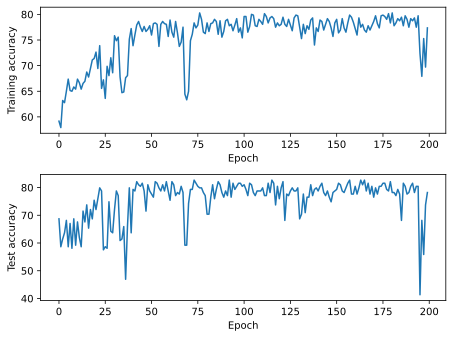

In [271]:
fig = plt.figure(tight_layout=True)
gs = gridspec.GridSpec(nrows=2, ncols=1)

ax = fig.add_subplot(gs[0, 0])
ax.plot(train_accuracies)
ax.set_xlabel("Epoch")
ax.set_ylabel("Training accuracy")

ax = fig.add_subplot(gs[1, 0])
ax.plot(test_accuracies)
ax.set_xlabel("Epoch")
ax.set_ylabel("Test accuracy")

fig.align_labels()
plt.show()

In [272]:
np.mean(train_accuracies)

75.58958329161008

In [273]:
np.mean(test_accuracies)

75.85754184424877

In [274]:
X = torch.tensor(df2.values, dtype=torch.float)
print(X.shape)

torch.Size([418, 7])


In [275]:
preds = model(X)
pred_labels = torch.argmax(preds, axis=1)
pred_labels

tensor([0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1,
        1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0,
        1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0,
        1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0,
        1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1,
        1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0,
        0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0,
        0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1,
        1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
        0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0,
        0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0,

In [276]:
df2['Survived']=pred_labels

In [278]:
df2.head(10)

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Survived
0,892,3,0,34.5,0,0,7.8292,0
1,893,3,1,47.0,1,0,7.0000,0
2,894,2,0,62.0,0,0,9.6875,0
3,895,3,0,27.0,0,0,8.6625,0
4,896,3,1,22.0,1,1,12.2875,1
5,897,3,0,14.0,0,0,9.2250,0
6,898,3,1,30.0,0,0,7.6292,1
7,899,2,0,26.0,1,1,29.0000,0
8,900,3,1,18.0,0,0,7.2292,1
9,901,3,0,21.0,2,0,24.1500,0
